# **STEMfit example**

This notebook gives a short demonstration of how to detect atoms in a STEM image and determine the unit cell. First, we start by importing `STEMfit` and `Plots`:

In [29]:
#using Pkg; Pkg.activate("X:\\Documents\\virtualenvs\\Julia_STEMfit");
using Pkg; Pkg.activate("C:\\Users\\ewout\\Documents\\venv\\Julia-STEMfit");
using Revise
import STEMfit
using Plots


  Activating project at `C:\Users\ewout\Documents\venv\Julia-STEMfit`


Now, we load our example image. The image we use here is of three oxide perovskite layers grown epitaxially on each other. By setting `convert=true`, we let `STEMfit` convert our 16 bit TIFF image into the required format.

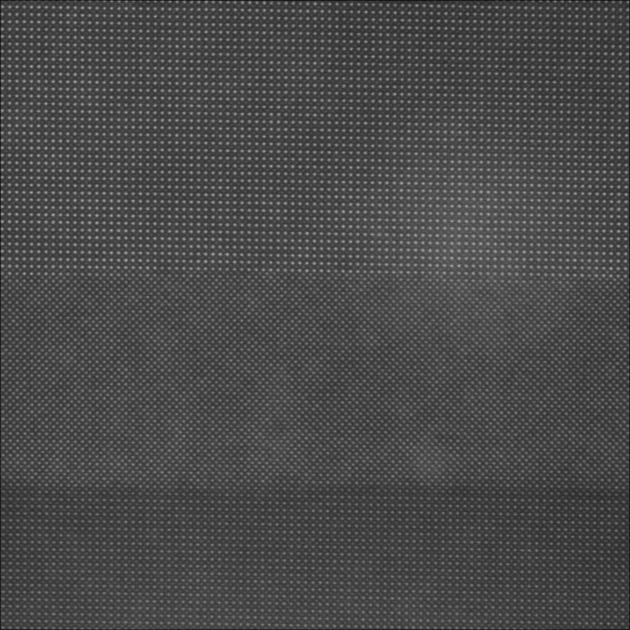

In [30]:
image = STEMfit.load_image("image.tif", convert=true)

We filter the raw image using a combination of singular value decomposition and Gaussian convolution. The number of singular vectors to keep is set by the `num_sv` parameter. We can use the vector of singular values (Σ) returned by the `filter_image` function to find the correct value. In this case 30 singular vectors is enough. Generally, the default value of 30 should work for most images. 

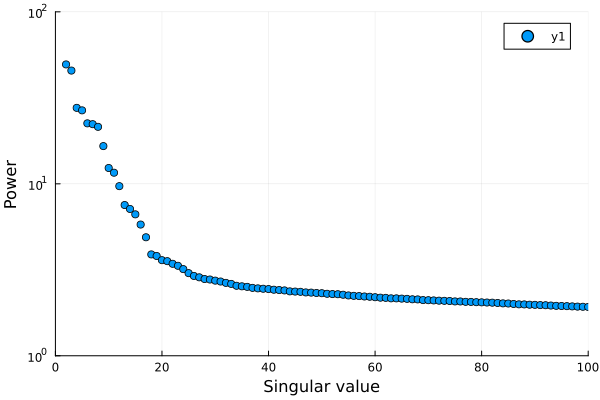

In [31]:
(filtered_image, Σ)  = STEMfit.filter_image(image)

# Visualize the power of each singular vector 
scatter(Σ, yaxis=:log, xlim=(0,100), ylim=(1, 100), xlabel="Singular value", ylabel="Power")

Then, we use the `find_atoms` function to find atoms in the image using an adaptive thresholding procedure. The function takes the image as an argument as well as `bias` and `window_size` parameters which control the thresholding. Increasing `bias` tends to make the threshold higher (i.e. more separation of atoms), `window_size` determines how big of an area is considered at each point in the image. The function returns a matrix of atom positions, a vector of atom widths, a vector of atom intensities and the thresholded image. The latter can be used to assess the quality of the thresholding and asjust the `bias` and `window_size` parameters. 

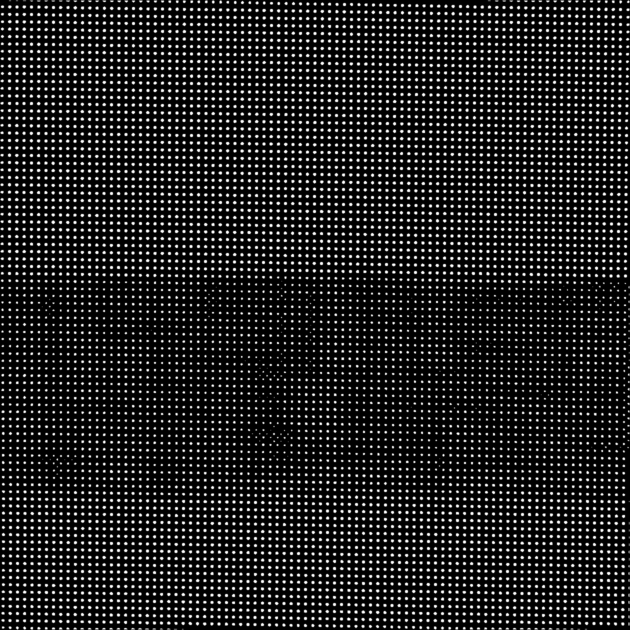

In [32]:
(atom_positions, atom_widths, atom_intensities, thresholded_image) = STEMfit.find_atoms(filtered_image, bias=1.5, window_size=8)
thresholded_image

The atomic positions are returned as a 2xn matrix, where each first value is the y-position of the atom and each second value is the x-position (both in pixel units).

In [33]:
atom_positions

2×7494 Matrix{Float32}:
 102.0   117.0   131.84  161.385    …  1204.27  1218.5  1233.27  1247.5
   4.16    4.16    4.0     3.92308     1257.55  1257.5  1257.55  1257.5

Let's plot the atomic positions on top of the image:

In [34]:
plot(image)
scatter!(atom_positions[2,:], atom_positions[1,:], markersize=2, markerstrokewidth=0, c=:red, legend=false, size=(1000,1000), xaxis=false, yaxis=false)

Almost all A-site atoms are detected. We could try to adjust the parameters a bit to also detect the last few A-site atoms, but for now we will move on.
We save the atom positions to a CSV file: 

In [35]:
STEMfit.save_atomic_positions!("atomic_positions.csv", [atom_positions' atom_widths atom_intensities],
                                headers = ["y(px)", "x(px)", "width(px)", "intensity(arb.unit)"])

`STEMfit` will now try to find potential unit cells in the atomic positions. To do this, it finds clusters in the vectors between each pair of atoms using the [DBSCAN](https://www.wikiwand.com/en/DBSCAN) algorithm. Any two of such vectors may form the side of a possible unit cell. We restrict the angle of the unit cell to 85-95 degrees (i.e. a rectangular unit cell) using the `uc_allowed_angles` parameter and use the default settings for all other parameters. 

In [36]:
(unit_cells, neighbors, atom_tree) = STEMfit.find_unit_cells(atom_positions, uc_allowed_angles=85:95);

Let's plot the first ten unit cells we found (sorted by unit cell area) to see if we found the right one. The `plot_unit_cells` function takes a vector of unit cells as input as well as a matrix of 'neighbors'. These neighbors represent the *average* local environment of each atom in the image.  

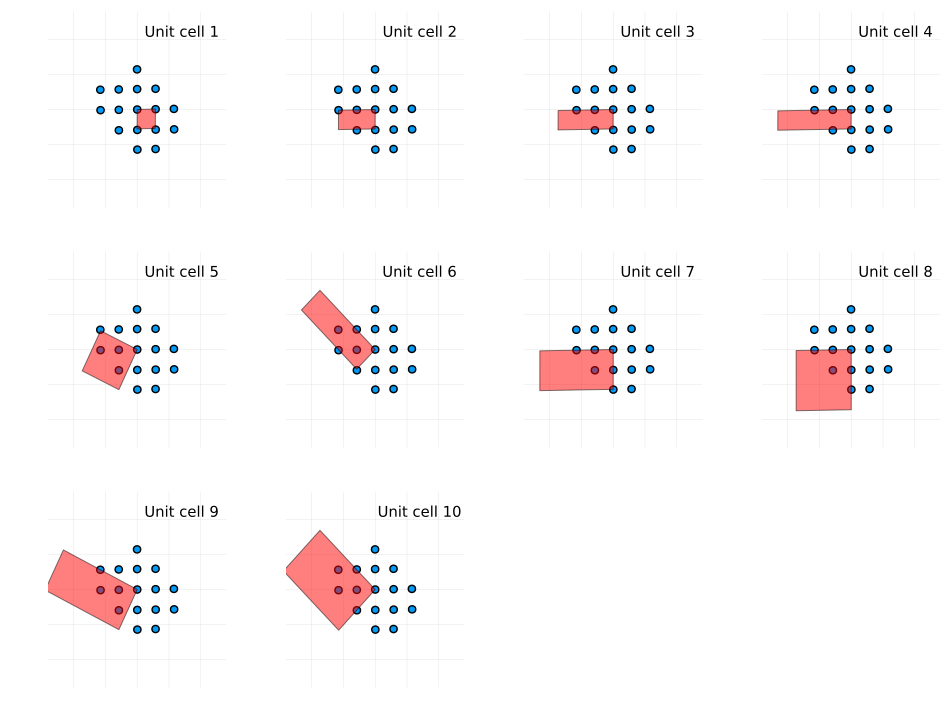

In [37]:
STEMfit.plot_unit_cells(unit_cells[1:10], neighbors)

It seems like `STEMfit` found the correct unit cell (Unit cell 1). Bear in mind that this unit cell represents the *average* translational symmetry in the whole image. To transform our atomic positions (in pixel units) to positions in length units (e.g. nm), we can use part of the image as a reference. In this case, the bottom ~1/5 of the image is a substrate with known lattice parameters. We can construct the unit cell of this reference by considering only atoms with a y-index larger that 80% of the height of the image:

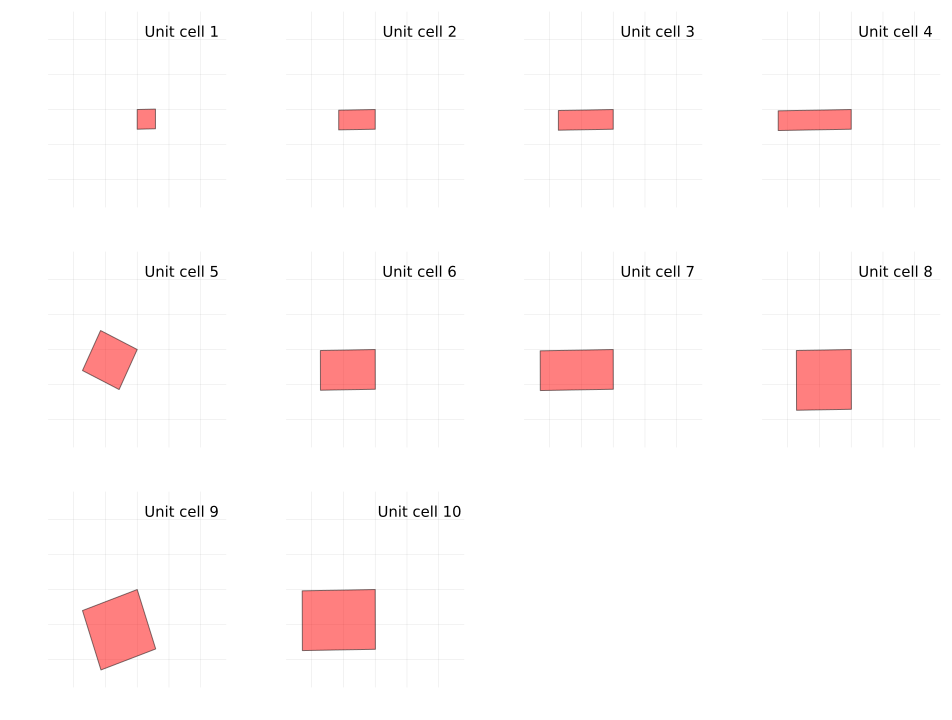

In [38]:
#Select only atoms in the bottom 20% of the image
substrate_min_y = size(image)[1]*0.8
reference_atom_positions = atom_positions[:, atom_positions[1,:] .> substrate_min_y]

(reference_unit_cells, _, _) = STEMfit.find_unit_cells(reference_atom_positions, uc_allowed_angles=85:95);
STEMfit.plot_unit_cells(reference_unit_cells[1:10])

As expected, we find the same set of unit cells. The first one again seems to be the correct unit cell. Since the reference in this image is SrTiO<sub>3</sub>, we know that each basis vector corresponds to a distance of 0.3905 nm. We can use this fact to transform out atomic positions into length units. We ask the `get_pixel_size` function to return the in-plane and out-of-plane pixel sizes separately by setting `return_two_sizes=true`, because there is a relatively large difference between the two likely due to drift in the image. Since the unit cell we use for the reference and for the full image are the same, we can safely continue by treating the in-plane and out-of-plane directions separately. If they were different, we would have to do some extra calculations. 

In [39]:
pixel_sizes = STEMfit.get_pixel_size(reference_unit_cells[1], (0.3905, 0.3905), return_two_sizes=true)

(0.0276756607110704, 0.02721465893423695)

We can now transform our atomic positions into length units. 

In [40]:
atom_positions_in_nm = STEMfit.transform_positions(atom_positions, pixel_sizes)

2×7494 Matrix{Float64}:
 2.82292   3.23805   3.64876   …  33.329   33.7228  34.1316  34.5254
 0.113213  0.113213  0.108859     34.2237  34.2224  34.2237  34.2224

Let's include the atomic positions in nanometers in our previously created CSV file:

In [41]:
STEMfit.save_atomic_positions!("atomic_positions.csv", [atom_positions' atom_positions_in_nm' atom_widths atom_intensities],
                                headers = ["y(px)", "x(px)", "y(nm)", "x(nm)", "width(px)", "intensity(arb.unit)"])

The next step is to calculate the local lattice parameter for each atom. We use the `calculate_lattice_parameters` function using the average unit cell we found before and otherwise standard settings. Then we use the pixel sizes we found using the SrTiO<sub>3</sub> reference to transform the lattice parameter into units of nanometers.  

In [204]:
lattice_parameters = STEMfit.calculate_lattice_parameters(atom_positions, unit_cells[1])
lattice_parameters_in_nm = pixel_sizes .* lattice_parameters;

In [233]:

@code_warntype STEMfit.calculate_lattice_parameters(atom_positions, unit_cells[1])

MethodInstance for STEMfit.calculate_lattice_parameters(::Matrix{Float32}, ::STEMfit.UnitCell)
  from calculate_lattice_parameters(positions::AbstractMatrix{T}, unit_cell::STEMfit.UnitCell; tolerance) where T<:Real in STEMfit at C:\Users\ewout\Documents\GitHub\STEMfit\src\latticeparameter.jl:2
Static Parameters
  T = Float32
Arguments
  #self#::Core.Const(STEMfit.calculate_lattice_parameters)
  positions::Matrix{Float32}
  unit_cell::STEMfit.UnitCell
Body::AbstractMatrix{Float32}
1 ─ %1 = STEMfit.:(var"#calculate_lattice_parameters#72")(0.2, #self#, positions, unit_cell)::AbstractMatrix{Float32}
└──      return %1



Let's inspect the results using a histogram. The lattice parameters we calculated above are defined along the two basis vectors of the unit cell. In this case, those correspond to the in-plane/horizontal and the out-of-plane/vertical direction, respectively. However, this depends on the choice of unit cell (for example, had we chosen Unit cell 5, the basis vectors would be rotated 30<sup>o</sup> with respect to the horizontal and vertical directions). 

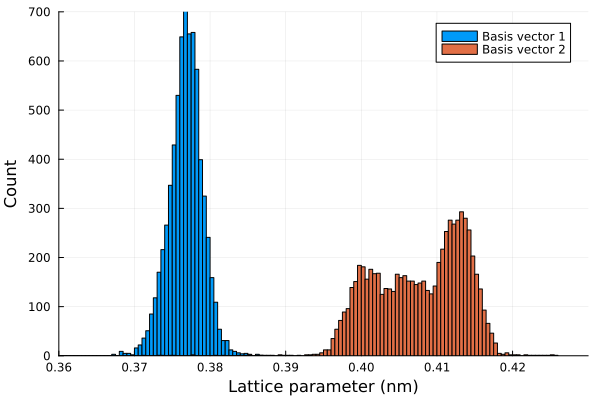

In [205]:
histogram(lattice_parameters_in_nm[1,:], 
            xlim=(0.36,0.43), 
            ylim=(0,700), 
            bins=1000, 
            label="Basis vector 1", 
            xlabel="Lattice parameter (nm)",
            ylabel="Count")
histogram!(lattice_parameters_in_nm[2,:], 
            bins=1000, 
            label="Basis vector 2")

As we can see, basis vector 1 (in-plane) is smaller than basis vector 2 (out-of-plane), which we expect to see for a compressively strained epitaxial film such as the present example. Furthermore, three distinct peaks are visible in the out-of-plane direction, corresponding to the three layers of the film. The in-plane direction shows only a single peak, indicating little to no strain relaxation. Finally, we plot the results as a lattice parameter map. We filter out the atoms for which no accurate lattice parameter information could be calculated.

In [214]:
atom_zero_filter = map(vec -> vec[1] && vec[2], eachcol(lattice_parameters .!= [0.0, 0.0]))

filtered_atoms = atom_positions_in_nm[:, atom_zero_filter]
filtered_lattice_parameters = clamp.(lattice_parameters_in_nm[:, atom_zero_filter], 0.37,0.42);

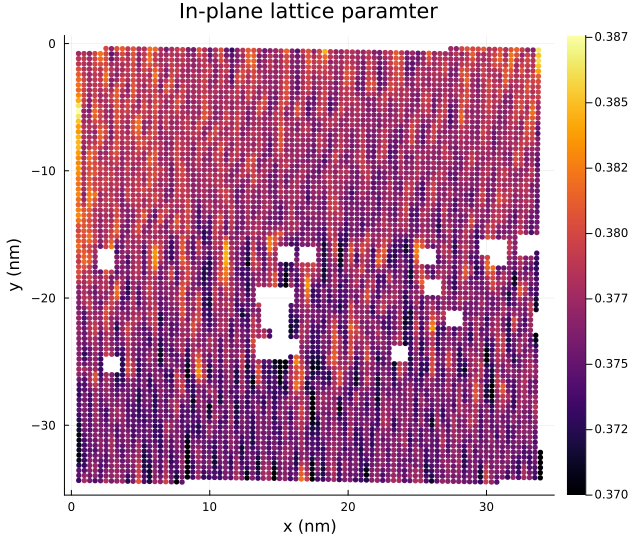

In [228]:
#Basis vector 1/in-plane
scatter(filtered_atoms[2, :],
        -filtered_atoms[1, :],
        marker_z=filtered_lattice_parameters[1,:],
        size=size(image)./(2,2.3),
        markerstrokewidth=0,
        markersize=3,
        xlabel="x (nm)",
        ylabel="y (nm)",
        title="In-plane lattice paramter",
        label=false,
        c=cgrad(:inferno))

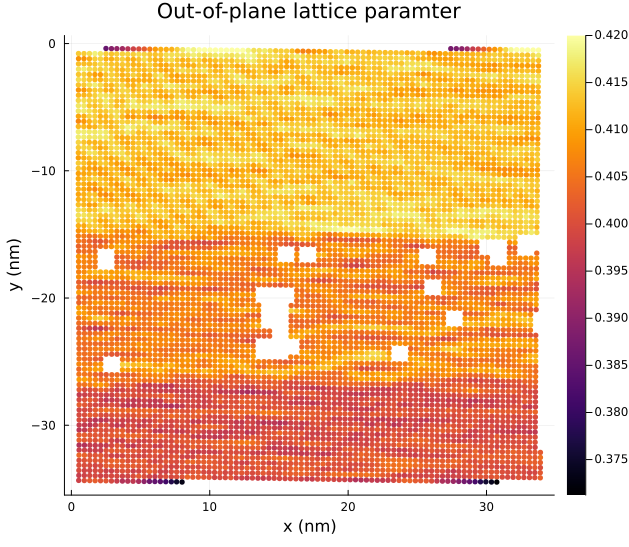

In [224]:
#Basis vector 2/out-of-plane
scatter(filtered_atoms[2, :],
        -filtered_atoms[1, :],
        marker_z=filtered_lattice_parameters[2,:],
        size=size(image)./(2,2.3),
        markerstrokewidth=0,
        markersize=3,
        xlabel="x (nm)",
        ylabel="y (nm)",
        title="Out-of-plane lattice paramter",
        label=false,
        c=cgrad(:inferno))